In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

warnings.filterwarnings("ignore")

data = pd.read_csv("M:/DataSet/usaccident/real/selectData.csv",index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212697 entries, 0 to 212696
Columns: 312 entries, TMC to yorkrockhillkuza29730
dtypes: float64(10), int64(302)
memory usage: 507.9 MB


1.数据集划分
=

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler

Y = data['Severity']
X = data.drop(["Severity"], axis=1)

del data

X.shape, Y.shape

((212697, 311), (212697,))

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2,random_state=10,stratify=Y_train)

X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((136125, 311), (42540, 311), (34032, 311), (136125,), (42540,), (34032,))

2.过采样
=
Note：
对整个数据集数据标准化后再划分训练集、测试集和先对训练级标准化再将规则用于测试集的区别？<br>
Ans：如果是做案例类学习研究，由于数据量是固定的，其实这两种方式不会有太大的区别，但是在实际的业务应用中，第二种方式还是会比第一种方式更可靠，因为会有实时的数据集进来应用模型，而这时的数据处理规则仍然采用建模前的规则会有一定的容错率。简单来说，不同测试集的标准化方式应该都和训练集一致，这样才能根据训练集训练出的模型进行推断。

In [4]:
from collections import Counter

from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold,GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.tree import plot_tree
from imblearn import over_sampling

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [5]:
ros = over_sampling.RandomOverSampler(random_state=12)

X_train, Y_train = ros.fit_resample(X_train, Y_train)

print(sorted(Counter(Y_train).items()))

[(1, 111548), (2, 111548), (3, 111548), (4, 111548)]


In [6]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

3.Model
=

DecisionTree
=

In [7]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, Y_train)

pred_dt = dtree.predict(X_test)
y_train_pred = dtree.predict(X_train[:30000])

# acc_train = accuracy_score(Y_train[:30000],y_train_pred)
# acc_dt = accuracy_score(Y_test, pred_dt)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)
mat_dt = confusion_matrix(Y_test, pred_dt)

# print(f"Train Acc : {acc_train}")
# print(f"\nTest Acc : {acc_dt}")
print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_dt}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_dt))

del pred_dt, y_train_pred

confusion matrix :
[[   15     0     0     0]
 [    0 24652    13    22]
 [    0     0  5064     0]
 [    0     0     0   234]]

confusion matrix :
[[    7    17     1     0]
 [   20 31568  3082   189]
 [    4  3058  4211    54]
 [    0   179    54    96]]

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00     24687
           3       1.00      1.00      1.00      5064
           4       0.91      1.00      0.96       234

    accuracy                           1.00     30000
   macro avg       0.98      1.00      0.99     30000
weighted avg       1.00      1.00      1.00     30000

              precision    recall  f1-score   support

           1       0.23      0.28      0.25        25
           2       0.91      0.91      0.91     34859
           3       0.57      0.57      0.57      7327
           4       0.28      0.29      0.29       329

    accuracy                       

In [8]:
dt_params = {
    'criterion':['gini','entropy'],
    'max_depth':[8,10,12,14,16]
}
clf = GridSearchCV(dtree, param_grid=dt_params,cv=5,scoring='recall',n_jobs=-1)
clf.fit(X_val, Y_val)

# print(f"Accuracy : {clf.best_score_}")
# print(f"Best Params :\n{clf.best_params_}")

dtree = DecisionTreeClassifier(**clf.best_params_)
dtree.fit(X_train, Y_train)

pred_dt = dtree.predict(X_test)
y_train_pred = dtree.predict(X_train[:30000])

# acc_train = accuracy_score(Y_train[:30000],y_train_pred)
# acc_dt = accuracy_score(Y_test, pred_dt)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)
mat_dt = confusion_matrix(Y_test, pred_dt)

# print(f"Train Acc : {acc_train}")
# print(f"Test Acc : {acc_dt}")
print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_dt}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_dt))

del pred_dt, y_train_pred

confusion matrix :
[[   13     0     2     0]
 [ 1675 11788  8579  2645]
 [  182   149  4517   216]
 [    0     0    16   218]]

confusion matrix :
[[   13     7     5     0]
 [ 2384 16442 12336  3697]
 [  320   253  6413   341]
 [    2    23    24   280]]

              precision    recall  f1-score   support

           1       0.01      0.87      0.01        15
           2       0.99      0.48      0.64     24687
           3       0.34      0.89      0.50      5064
           4       0.07      0.93      0.13       234

    accuracy                           0.55     30000
   macro avg       0.35      0.79      0.32     30000
weighted avg       0.87      0.55      0.61     30000

              precision    recall  f1-score   support

           1       0.00      0.52      0.01        25
           2       0.98      0.47      0.64     34859
           3       0.34      0.88      0.49      7327
           4       0.06      0.85      0.12       329

    accuracy                       

RandomForest
=

In [9]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=15)
rfc.fit(X_train,Y_train)

pred_rfc = rfc.predict(X_test)
y_train_pred = rfc.predict(X_train[:30000])

# acc_rfc = accuracy_score(Y_test, pred_rfc)
# acc_train = accuracy_score(Y_train[:30000],y_train_pred)
mat_rfc = confusion_matrix(Y_test, pred_rfc)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

# print(f"Train Acc : {acc_train}")
# print(f"\nTest Acc : {acc_rfc}\n")

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_rfc}\n")

print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_rfc))

del pred_rfc, y_train_pred

confusion matrix :
[[   15     0     0     0]
 [   64 15098  7473  2052]
 [   10   163  4698   193]
 [    0     0     4   230]]

confusion matrix :
[[   10    10     5     0]
 [   88 20715 11061  2995]
 [   16   451  6535   325]
 [    0    20    17   292]]

              precision    recall  f1-score   support

           1       0.17      1.00      0.29        15
           2       0.99      0.61      0.76     24687
           3       0.39      0.93      0.55      5064
           4       0.09      0.98      0.17       234

    accuracy                           0.67     30000
   macro avg       0.41      0.88      0.44     30000
weighted avg       0.88      0.67      0.72     30000

              precision    recall  f1-score   support

           1       0.09      0.40      0.14        25
           2       0.98      0.59      0.74     34859
           3       0.37      0.89      0.52      7327
           4       0.08      0.89      0.15       329

    accuracy                       

In [10]:
rfc_params = {
    "n_estimators" : [150, 200],
    'max_depth' : [11,15,19]
}
clf = GridSearchCV(rfc, param_grid=rfc_params, scoring='recall',cv=5,n_jobs=-1)
clf.fit(X_val, Y_val)

rfc = RandomForestClassifier(**clf.best_params_)
rfc.fit(X_train,Y_train)

pred_rfc = rfc.predict(X_test)
y_train_pred = rfc.predict(X_train[:30000])

# acc_rfc = accuracy_score(Y_test, pred_rfc)
# acc_train = accuracy_score(Y_train[:30000],y_train_pred)
mat_rfc = confusion_matrix(Y_test, pred_rfc)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

# print(f"Train Acc : {acc_train}")
# print(f"\nTest Acc : {acc_rfc}\n")

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_rfc}\n")

print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_rfc))

del pred_rfc,y_train_pred

confusion matrix :
[[   15     0     0     0]
 [  165 13280  8062  3180]
 [   20   203  4601   240]
 [    0     0     8   226]]

confusion matrix :
[[   13     7     5     0]
 [  239 18384 11807  4429]
 [   34   381  6541   371]
 [    1     3    14   311]]

              precision    recall  f1-score   support

           1       0.07      1.00      0.14        15
           2       0.98      0.54      0.70     24687
           3       0.36      0.91      0.52      5064
           4       0.06      0.97      0.12       234

    accuracy                           0.60     30000
   macro avg       0.37      0.85      0.37     30000
weighted avg       0.87      0.60      0.66     30000

              precision    recall  f1-score   support

           1       0.05      0.52      0.08        25
           2       0.98      0.53      0.69     34859
           3       0.36      0.89      0.51      7327
           4       0.06      0.95      0.11       329

    accuracy                       

XGB
=

In [11]:
xgb = XGBClassifier()
xgb.fit(X_train, Y_train)
pred_xgb = xgb.predict(X_test)
y_train_pred = xgb.predict(X_train[:30000])

# acc_xgb = accuracy_score(Y_test, pred_xgb)
# acc_train = accuracy_score(Y_train[:30000],y_train_pred)
mat_xgb = confusion_matrix(Y_test, pred_xgb)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

# print(f"Train Acc : {acc_train}")
# print(f"Test Accuracy : {acc_xgb}\n")
print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_xgb}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_xgb))

del pred_xgb, y_train_pred

[19:42:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix :
[[   15     0     0     0]
 [   39 18809  4813  1026]
 [    3   175  4744   142]
 [    0     0     0   234]]

confusion matrix :
[[   12    12     1     0]
 [   61 26197  7062  1539]
 [    5   366  6698   258]
 [    0    58    29   242]]

              precision    recall  f1-score   support

           1       0.26      1.00      0.42        15
           2       0.99      0.76      0.86     24687
           3       0.50      0.94      0.65      5064
           4       0.17      1.00      0.29       234

    accuracy                           0.79     30000
   macro avg       0.48      0.92      0.55     30000
weighted avg       0.90      0.79      0.82     300

In [14]:
xgb_params = {
    'max_depth' : [1,3,5],
    'n_estimators' : [150,200]
}

clf = GridSearchCV(xgb, param_grid=xgb_params,cv=5,scoring='recall')
clf.fit(X_val, Y_val)

# print(f"Accuracy : {clf.best_score_}")
# print(f"Best Params :\n{clf.best_params_}")

xgb = XGBClassifier(**clf.best_params_)
xgb.fit(X_train, Y_train)
pred_xgb = xgb.predict(X_test)
y_train_pred = xgb.predict(X_train[:30000])

# acc_xgb = accuracy_score(Y_test, pred_xgb)
# acc_train = accuracy_score(Y_train[:30000],y_train_pred)
mat_xgb = confusion_matrix(Y_test, pred_xgb)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

# print(f"Train Acc : {acc_train}")
# print(f"Test Accuracy : {acc_xgb}\n")
print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_xgb}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_xgb))

del pred_xgb, y_train_pred

[19:52:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:53:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:53:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:53:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[20:03:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:04:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:05:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:05:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

LGBM
=

In [15]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()
lgbm.fit(X_train, Y_train)
pred_lgbm = lgbm.predict(X_test)
y_train_pred = lgbm.predict(X_train[:30000])

# acc_lgbm = accuracy_score(Y_test, pred_lgbm)
# acc_train = accuracy_score(Y_train[:30000],y_train_pred)
mat_lgbm = confusion_matrix(Y_test, pred_lgbm)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

# print(f"Train Acc : {acc_train}")
# print(f"Test Accuracy : {acc_lgbm}\n")
print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_lgbm}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_lgbm))

del pred_lgbm, y_train_pred

confusion matrix :
[[   15     0     0     0]
 [   37 18873  4604  1173]
 [    2   225  4676   161]
 [    0     0     0   234]]

confusion matrix :
[[   12    12     1     0]
 [   56 26476  6639  1688]
 [    5   359  6682   281]
 [    0    47    24   258]]

              precision    recall  f1-score   support

           1       0.28      1.00      0.43        15
           2       0.99      0.76      0.86     24687
           3       0.50      0.92      0.65      5064
           4       0.15      1.00      0.26       234

    accuracy                           0.79     30000
   macro avg       0.48      0.92      0.55     30000
weighted avg       0.90      0.79      0.82     30000

              precision    recall  f1-score   support

           1       0.16      0.48      0.24        25
           2       0.98      0.76      0.86     34859
           3       0.50      0.91      0.65      7327
           4       0.12      0.78      0.20       329

    accuracy                       

CATBOOST
=

In [16]:
cat = CatBoostClassifier()
logs = cat.fit(X_train, Y_train)

pred_cat = cat.predict(X_test)
y_train_pred = cat.predict(X_train[:30000])

# acc_cat = accuracy_score(Y_test, pred_cat)
# acc_train = accuracy_score(Y_train[:30000],y_train_pred)
mat_cat = confusion_matrix(Y_test, pred_cat)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

# print(f"Train Acc : {acc_train}")
# print(f"Test Acc : {acc_cat}\n")
print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_cat}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_cat))

del pred_cat,y_train_pred

Learning rate set to 0.108006
0:	learn: 1.2554253	total: 254ms	remaining: 4m 13s
1:	learn: 1.1594735	total: 437ms	remaining: 3m 38s
2:	learn: 1.0848787	total: 630ms	remaining: 3m 29s
3:	learn: 1.0247578	total: 823ms	remaining: 3m 25s
4:	learn: 0.9760036	total: 988ms	remaining: 3m 16s
5:	learn: 0.9330570	total: 1.16s	remaining: 3m 11s
6:	learn: 0.8985319	total: 1.31s	remaining: 3m 6s
7:	learn: 0.8688107	total: 1.48s	remaining: 3m 3s
8:	learn: 0.8407062	total: 1.65s	remaining: 3m 1s
9:	learn: 0.8153639	total: 1.82s	remaining: 3m
10:	learn: 0.7958320	total: 1.98s	remaining: 2m 58s
11:	learn: 0.7743735	total: 2.17s	remaining: 2m 58s
12:	learn: 0.7556520	total: 2.35s	remaining: 2m 58s
13:	learn: 0.7406794	total: 2.52s	remaining: 2m 57s
14:	learn: 0.7273839	total: 2.67s	remaining: 2m 55s
15:	learn: 0.7136154	total: 2.83s	remaining: 2m 54s
16:	learn: 0.7018089	total: 3.02s	remaining: 2m 54s
17:	learn: 0.6918392	total: 3.17s	remaining: 2m 53s
18:	learn: 0.6840807	total: 3.33s	remaining: 2m 52s

158:	learn: 0.3690384	total: 29.5s	remaining: 2m 35s
159:	learn: 0.3686664	total: 29.6s	remaining: 2m 35s
160:	learn: 0.3680634	total: 29.8s	remaining: 2m 35s
161:	learn: 0.3674510	total: 30s	remaining: 2m 35s
162:	learn: 0.3666956	total: 30.2s	remaining: 2m 35s
163:	learn: 0.3662209	total: 30.4s	remaining: 2m 34s
164:	learn: 0.3656716	total: 30.5s	remaining: 2m 34s
165:	learn: 0.3653577	total: 30.7s	remaining: 2m 34s
166:	learn: 0.3642776	total: 30.9s	remaining: 2m 34s
167:	learn: 0.3638202	total: 31.1s	remaining: 2m 33s
168:	learn: 0.3634057	total: 31.2s	remaining: 2m 33s
169:	learn: 0.3630051	total: 31.4s	remaining: 2m 33s
170:	learn: 0.3625771	total: 31.6s	remaining: 2m 33s
171:	learn: 0.3623460	total: 31.8s	remaining: 2m 33s
172:	learn: 0.3620527	total: 32s	remaining: 2m 32s
173:	learn: 0.3608322	total: 32.2s	remaining: 2m 32s
174:	learn: 0.3600677	total: 32.4s	remaining: 2m 32s
175:	learn: 0.3595301	total: 32.6s	remaining: 2m 32s
176:	learn: 0.3588983	total: 32.8s	remaining: 2m 3

315:	learn: 0.3007131	total: 59.2s	remaining: 2m 8s
316:	learn: 0.3000661	total: 59.5s	remaining: 2m 8s
317:	learn: 0.2995296	total: 59.6s	remaining: 2m 7s
318:	learn: 0.2993637	total: 59.8s	remaining: 2m 7s
319:	learn: 0.2990214	total: 60s	remaining: 2m 7s
320:	learn: 0.2987066	total: 1m	remaining: 2m 7s
321:	learn: 0.2986124	total: 1m	remaining: 2m 7s
322:	learn: 0.2983721	total: 1m	remaining: 2m 6s
323:	learn: 0.2981178	total: 1m	remaining: 2m 6s
324:	learn: 0.2978640	total: 1m	remaining: 2m 6s
325:	learn: 0.2977675	total: 1m 1s	remaining: 2m 6s
326:	learn: 0.2975011	total: 1m 1s	remaining: 2m 5s
327:	learn: 0.2973458	total: 1m 1s	remaining: 2m 5s
328:	learn: 0.2969646	total: 1m 1s	remaining: 2m 5s
329:	learn: 0.2967957	total: 1m 1s	remaining: 2m 5s
330:	learn: 0.2966107	total: 1m 1s	remaining: 2m 5s
331:	learn: 0.2962000	total: 1m 2s	remaining: 2m 4s
332:	learn: 0.2960312	total: 1m 2s	remaining: 2m 4s
333:	learn: 0.2958833	total: 1m 2s	remaining: 2m 4s
334:	learn: 0.2950687	total: 

471:	learn: 0.2642080	total: 1m 29s	remaining: 1m 39s
472:	learn: 0.2639027	total: 1m 29s	remaining: 1m 39s
473:	learn: 0.2636257	total: 1m 29s	remaining: 1m 39s
474:	learn: 0.2633750	total: 1m 29s	remaining: 1m 39s
475:	learn: 0.2633255	total: 1m 29s	remaining: 1m 39s
476:	learn: 0.2631135	total: 1m 30s	remaining: 1m 38s
477:	learn: 0.2629534	total: 1m 30s	remaining: 1m 38s
478:	learn: 0.2627766	total: 1m 30s	remaining: 1m 38s
479:	learn: 0.2626431	total: 1m 30s	remaining: 1m 38s
480:	learn: 0.2623939	total: 1m 30s	remaining: 1m 38s
481:	learn: 0.2622045	total: 1m 31s	remaining: 1m 37s
482:	learn: 0.2621804	total: 1m 31s	remaining: 1m 37s
483:	learn: 0.2618831	total: 1m 31s	remaining: 1m 37s
484:	learn: 0.2616954	total: 1m 31s	remaining: 1m 37s
485:	learn: 0.2615484	total: 1m 31s	remaining: 1m 37s
486:	learn: 0.2612961	total: 1m 31s	remaining: 1m 36s
487:	learn: 0.2611363	total: 1m 32s	remaining: 1m 36s
488:	learn: 0.2609899	total: 1m 32s	remaining: 1m 36s
489:	learn: 0.2608280	total:

623:	learn: 0.2388166	total: 1m 58s	remaining: 1m 11s
624:	learn: 0.2386836	total: 1m 58s	remaining: 1m 11s
625:	learn: 0.2386153	total: 1m 58s	remaining: 1m 10s
626:	learn: 0.2383099	total: 1m 58s	remaining: 1m 10s
627:	learn: 0.2381065	total: 1m 59s	remaining: 1m 10s
628:	learn: 0.2380225	total: 1m 59s	remaining: 1m 10s
629:	learn: 0.2378964	total: 1m 59s	remaining: 1m 10s
630:	learn: 0.2378427	total: 1m 59s	remaining: 1m 10s
631:	learn: 0.2377046	total: 1m 59s	remaining: 1m 9s
632:	learn: 0.2376514	total: 2m	remaining: 1m 9s
633:	learn: 0.2375721	total: 2m	remaining: 1m 9s
634:	learn: 0.2373640	total: 2m	remaining: 1m 9s
635:	learn: 0.2372496	total: 2m	remaining: 1m 9s
636:	learn: 0.2369757	total: 2m	remaining: 1m 8s
637:	learn: 0.2368155	total: 2m 1s	remaining: 1m 8s
638:	learn: 0.2367371	total: 2m 1s	remaining: 1m 8s
639:	learn: 0.2366259	total: 2m 1s	remaining: 1m 8s
640:	learn: 0.2364488	total: 2m 1s	remaining: 1m 8s
641:	learn: 0.2362983	total: 2m 1s	remaining: 1m 7s
642:	learn

780:	learn: 0.2182111	total: 2m 27s	remaining: 41.4s
781:	learn: 0.2180062	total: 2m 27s	remaining: 41.2s
782:	learn: 0.2179212	total: 2m 27s	remaining: 41s
783:	learn: 0.2178315	total: 2m 28s	remaining: 40.8s
784:	learn: 0.2175747	total: 2m 28s	remaining: 40.6s
785:	learn: 0.2174375	total: 2m 28s	remaining: 40.4s
786:	learn: 0.2173619	total: 2m 28s	remaining: 40.2s
787:	learn: 0.2172263	total: 2m 28s	remaining: 40s
788:	learn: 0.2171282	total: 2m 28s	remaining: 39.8s
789:	learn: 0.2168795	total: 2m 29s	remaining: 39.6s
790:	learn: 0.2168061	total: 2m 29s	remaining: 39.5s
791:	learn: 0.2165328	total: 2m 29s	remaining: 39.3s
792:	learn: 0.2165200	total: 2m 29s	remaining: 39.1s
793:	learn: 0.2162758	total: 2m 29s	remaining: 38.9s
794:	learn: 0.2161486	total: 2m 30s	remaining: 38.7s
795:	learn: 0.2160568	total: 2m 30s	remaining: 38.5s
796:	learn: 0.2159478	total: 2m 30s	remaining: 38.3s
797:	learn: 0.2158882	total: 2m 30s	remaining: 38.1s
798:	learn: 0.2158294	total: 2m 30s	remaining: 37.

936:	learn: 0.2034373	total: 2m 57s	remaining: 11.9s
937:	learn: 0.2034149	total: 2m 57s	remaining: 11.7s
938:	learn: 0.2033760	total: 2m 57s	remaining: 11.5s
939:	learn: 0.2032904	total: 2m 57s	remaining: 11.4s
940:	learn: 0.2032499	total: 2m 58s	remaining: 11.2s
941:	learn: 0.2032179	total: 2m 58s	remaining: 11s
942:	learn: 0.2031590	total: 2m 58s	remaining: 10.8s
943:	learn: 0.2030109	total: 2m 58s	remaining: 10.6s
944:	learn: 0.2029175	total: 2m 58s	remaining: 10.4s
945:	learn: 0.2028587	total: 2m 59s	remaining: 10.2s
946:	learn: 0.2026928	total: 2m 59s	remaining: 10s
947:	learn: 0.2026035	total: 2m 59s	remaining: 9.85s
948:	learn: 0.2025417	total: 2m 59s	remaining: 9.66s
949:	learn: 0.2023902	total: 3m	remaining: 9.48s
950:	learn: 0.2022858	total: 3m	remaining: 9.29s
951:	learn: 0.2021682	total: 3m	remaining: 9.11s
952:	learn: 0.2021024	total: 3m	remaining: 8.92s
953:	learn: 0.2020573	total: 3m 1s	remaining: 8.73s
954:	learn: 0.2019627	total: 3m 1s	remaining: 8.54s
955:	learn: 0.2

In [17]:
cat = CatBoostClassifier(iterations=2000,learning_rate=0.1,max_depth=7,verbose=100,
                         early_stopping_rounds=500)
logs = cat.fit(X_train, Y_train)

pred_cat = cat.predict(X_test)
y_train_pred = cat.predict(X_train[:30000])

# acc_cat = accuracy_score(Y_test, pred_cat)
# acc_train = accuracy_score(Y_train[:30000],y_train_pred)
mat_cat = confusion_matrix(Y_test, pred_cat)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

# print(f"Train Acc : {acc_train}")
# print(f"Test Acc : {acc_cat}\n")
print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_cat}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_cat))

del pred_cat,y_train_pred

0:	learn: 1.2557553	total: 197ms	remaining: 6m 34s
100:	learn: 0.3898761	total: 18.9s	remaining: 5m 55s
200:	learn: 0.3188770	total: 38.2s	remaining: 5m 42s
300:	learn: 0.2777779	total: 59.9s	remaining: 5m 38s
400:	learn: 0.2527695	total: 1m 20s	remaining: 5m 21s
500:	learn: 0.2320457	total: 1m 42s	remaining: 5m 5s
600:	learn: 0.2174742	total: 2m 3s	remaining: 4m 46s
700:	learn: 0.2043790	total: 2m 24s	remaining: 4m 28s
800:	learn: 0.1939287	total: 2m 45s	remaining: 4m 8s
900:	learn: 0.1836114	total: 3m 7s	remaining: 3m 48s
1000:	learn: 0.1753820	total: 3m 28s	remaining: 3m 28s
1100:	learn: 0.1683799	total: 3m 50s	remaining: 3m 7s
1200:	learn: 0.1622829	total: 4m 11s	remaining: 2m 47s
1300:	learn: 0.1569156	total: 4m 32s	remaining: 2m 26s
1400:	learn: 0.1525024	total: 4m 53s	remaining: 2m 5s
1500:	learn: 0.1481006	total: 5m 16s	remaining: 1m 45s
1600:	learn: 0.1439822	total: 5m 37s	remaining: 1m 24s
1700:	learn: 0.1401558	total: 5m 57s	remaining: 1m 2s
1800:	learn: 0.1365106	total: 6m 

In [18]:
cat = CatBoostClassifier(iterations=10000,learning_rate=0.1,max_depth=7,verbose=100,
                         early_stopping_rounds=500)
logs = cat.fit(X_train, Y_train)

pred_cat = cat.predict(X_test)
y_train_pred = cat.predict(X_train[:30000])

# acc_cat = accuracy_score(Y_test, pred_cat)
# acc_train = accuracy_score(Y_train[:30000],y_train_pred)
mat_cat = confusion_matrix(Y_test, pred_cat)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

# print(f"Train Acc : {acc_train}")
# print(f"Test Acc : {acc_cat}\n")
print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_cat}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_cat))

del pred_cat,y_train_pred

0:	learn: 1.2557553	total: 191ms	remaining: 31m 52s
100:	learn: 0.3898761	total: 18s	remaining: 29m 19s
200:	learn: 0.3188770	total: 35.4s	remaining: 28m 44s
300:	learn: 0.2777779	total: 54.4s	remaining: 29m 13s
400:	learn: 0.2527695	total: 1m 13s	remaining: 29m 17s
500:	learn: 0.2320457	total: 1m 32s	remaining: 29m 21s
600:	learn: 0.2174742	total: 1m 52s	remaining: 29m 11s
700:	learn: 0.2043790	total: 2m 11s	remaining: 29m 6s
800:	learn: 0.1939287	total: 2m 31s	remaining: 28m 55s
900:	learn: 0.1836114	total: 2m 50s	remaining: 28m 46s
1000:	learn: 0.1753820	total: 3m 10s	remaining: 28m 34s
1100:	learn: 0.1683799	total: 3m 30s	remaining: 28m 20s
1200:	learn: 0.1622829	total: 3m 50s	remaining: 28m 6s
1300:	learn: 0.1569156	total: 4m 10s	remaining: 27m 52s
1400:	learn: 0.1525024	total: 4m 29s	remaining: 27m 35s
1500:	learn: 0.1481006	total: 4m 49s	remaining: 27m 18s
1600:	learn: 0.1439822	total: 5m 9s	remaining: 27m 4s
1700:	learn: 0.1401558	total: 5m 29s	remaining: 26m 47s
1800:	learn: 0

4.Result
=

In [19]:
result = pd.DataFrame({'clf':['DecisionTree','RandomForest','XGB-Default','XGB-Search','LGBM','CAT'],
                       'Severity-1':[52,52,48,56,48,44],
                       'Severity-2':[47,53,75,48,76,79],
                       'Severity-3':[88,89,91,85,91,91],
                       'Severity-4':[85,95,74,91,78,73]})

result

,clf,Severity-1,Severity-2,Severity-3,Severity-4
0,DecisionTree,52,47,88,85
1,RandomForest,52,53,89,95
2,XGB-Default,48,75,91,74
3,XGB-Search,56,48,85,91
4,LGBM,48,76,91,78
5,CAT,44,79,91,73


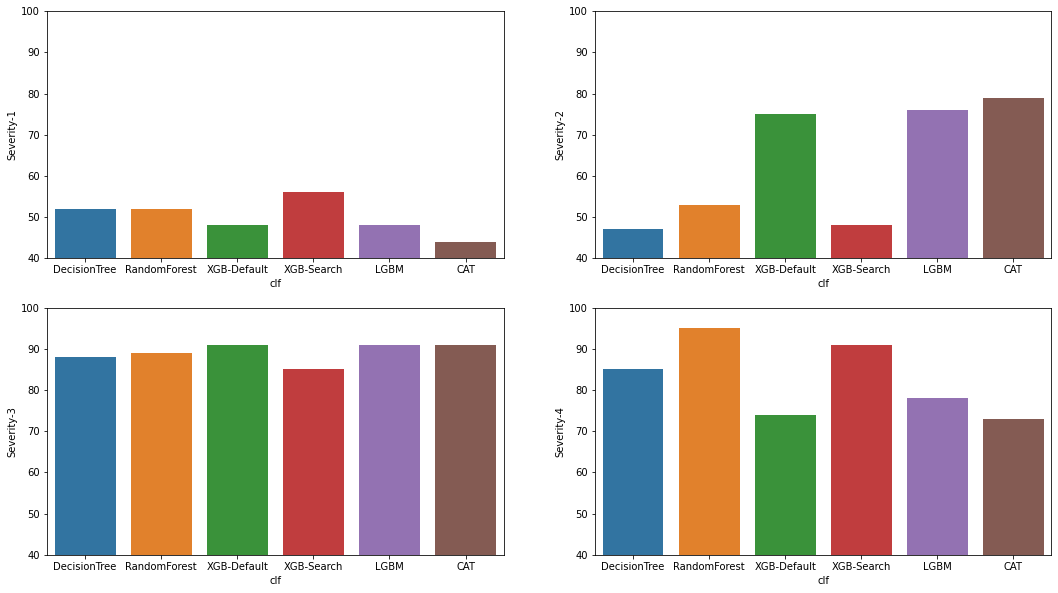

In [26]:
fig, ax = plt.subplots(2,2,figsize=(18,10))
sns.barplot(result['clf'],result['Severity-1'],ax=ax[0,0])
sns.barplot(result['clf'],result['Severity-2'],ax=ax[0,1])
sns.barplot(result['clf'],result['Severity-3'],ax=ax[1,0])
sns.barplot(result['clf'],result['Severity-4'],ax=ax[1,1])
ax[0,0].set_ylim(40,100)
ax[0,1].set_ylim(40,100)
ax[1,0].set_ylim(40,100)
ax[1,1].set_ylim(40,100)
plt.show()